# Interpretability methods applied on the FFNN used to awnser RQ1

## importing

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi']=200
device='cpu'

In [14]:
X_train = pd.read_csv('../datasets/Toy/X_train.csv',index_col=0)  
X_test = pd.read_csv('../datasets/Toy/X_test.csv',index_col=0)  
y_train = pd.read_csv('../datasets/Toy/y_train.csv',index_col=0)  
y_test = pd.read_csv('../datasets/Toy/y_test.csv',index_col=0) 
X_train_con=X_train.drop(columns=['x1'])
X_test_con=X_test.drop(columns=['x1'])
# Specify the split ratio. For example, let's use 80% for training and 20% for validation
split_ratio = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train_con, y_train, test_size=split_ratio, random_state=42)
# Sample 300 points from each dataset
# Set random seed for reproducibility
random_seed = 42
X_train_sample = X_train.sample(n=300, random_state=random_seed)
y_train_sample = y_train.loc[X_train_sample.index]

X_test_sample = X_test_con.sample(n=300, random_state=random_seed)
X_test_all_sample=X_test.loc[X_test_sample.index]
y_test_sample = y_test.loc[X_test_sample.index]

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_con)
X_test_scaled_sample = scaler.transform(X_test_sample)

In [16]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, hidden_layers, hidden_units, dropout, dropout_array, input_dim, output_dim, activation=nn.ReLU(),norm=False):
        if hidden_layers != len(hidden_units):
            print("Error: wrong size of hidden_layers or hidden_units")
            return
        layers = []
        i = 0
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        super(Net, self).__init__()
        
        layers.append(nn.Linear(input_dim, hidden_units[i]))
        layers.append(activation)
        if dropout:
            layers.append(nn.Dropout(dropout_array[i]))

        for _ in range(hidden_layers - 1):
            i += 1
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(activation)
            if dropout:
                layers.append(nn.Dropout(dropout_array[i]))

        layers.append(nn.Linear(hidden_units[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [17]:
config={'batch_size': 53, 'lr': 0.00038488608963589005, 'num_epochs': 100, 'hidden_layers': 3, 'hidden_units': [64, 32, 32], 'dropout': False, 'dropout_array': [0.38283509966903684, 0.14655095633529086, 0.5393755103727268], 'activation': nn.ReLU(), 'norm': True,'patience': 20}

input_dim = X_train_scaled.shape[1]
output_dim = 1

In [18]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))
val_ds = TensorDataset(torch.Tensor(X_val_scaled), torch.Tensor(y_val.to_numpy()))
test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [19]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [20]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
criterion = RMSELoss()

## Loading model

In [21]:
net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])

In [22]:
net.load_state_dict(torch.load('../Models/toy_model_confounder_9821'))
net.eval()

Net(
  (net): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)

## evaluation of the trained model

In [84]:
def plot_predictions(net, data_loader, device):
    net.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


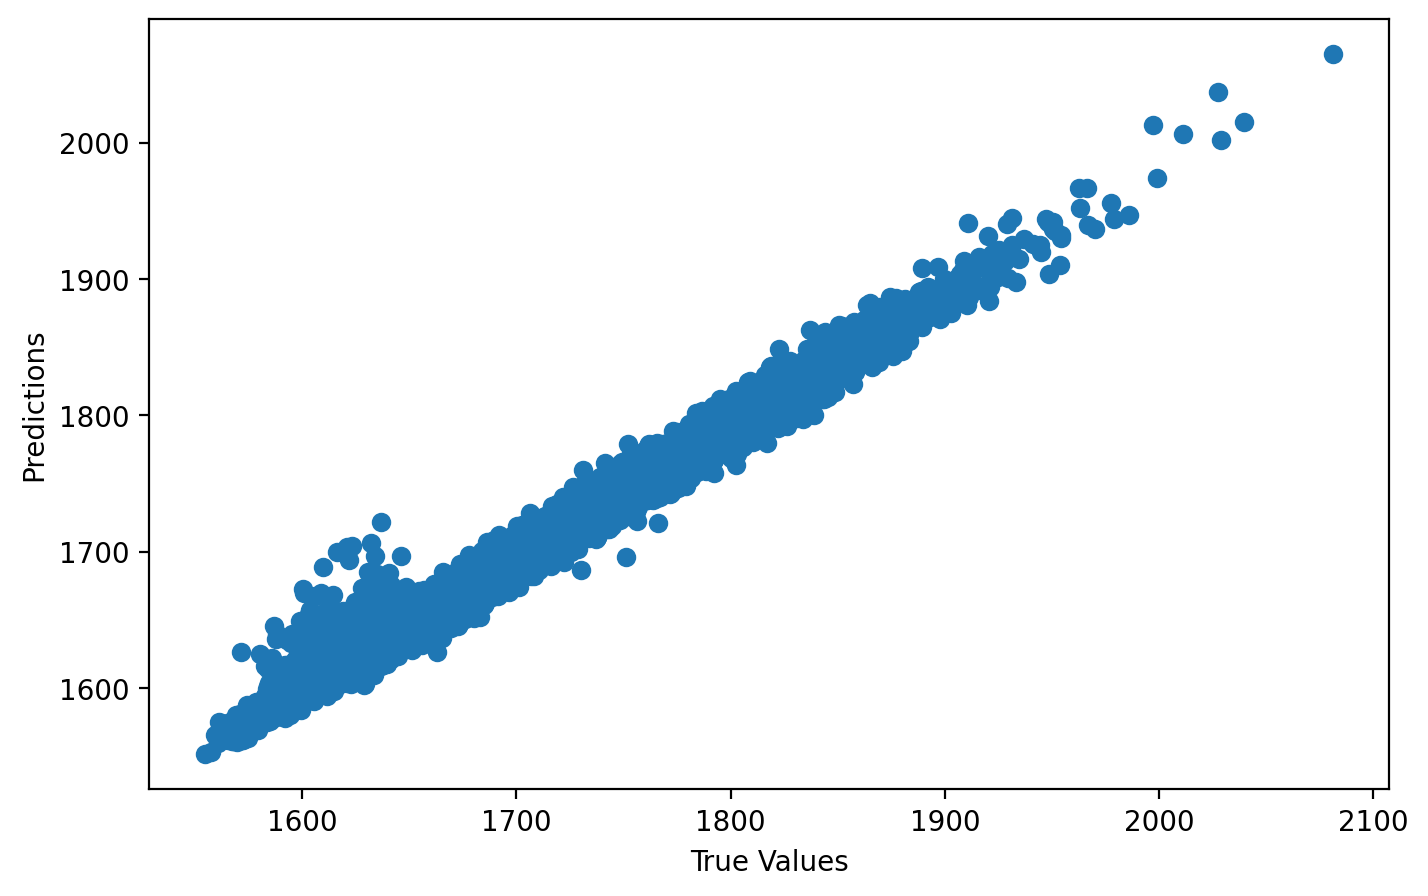

R^2 score: 0.9823175301678261
Train_loss: 6.924128532409668
Validation_loss: 6.896289825439453
Test_loss: 6.857640266418457


In [85]:
plot_predictions(net, test_loader, device)
y_true = np.array(y_test,dtype=object)
y_pred = net(torch.Tensor(X_test_scaled).to(device)).cpu().detach().numpy()
r2 = r2_score(y_true, y_pred)
print("R^2 score:", r2)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
print("Train_loss:",criterion(net(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item())
print("Validation_loss:",criterion(net(torch.Tensor(X_val_scaled).to(device)),y_val_tensor).item())
print("Test_loss:",criterion(net(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item())


## Truth-prediction-plot

In [86]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
def plot_prediction_vs_truth(model, X_s, X, y,title="Model Predictions vs Truth", num_points=None,):
    device = next(model.parameters()).device

    fig, ax = plt.subplots()

    # Fetch CGPA values directly from DataFrame X
    x1_values = X.loc[:, 'x1'].values
    normalized_x1 = (x1_values - np.min(x1_values)) / (np.max(x1_values) - np.min(x1_values))
    cmap = plt.get_cmap('coolwarm')  # Using 'coolwarm' colormap. You can choose any appropriate colormap.

    with torch.no_grad():
        model = model.eval()
        predictions = model(torch.tensor(X_s, dtype=torch.float, device=device)).cpu().numpy()


    # Ensure all arrays have the same length before looping
    assert len(y) == len(X_s) == len(normalized_x1), "Input arrays must have the same length"
    

    for i in range(len(X_s)):
        color = cmap(normalized_x1[i])
        plt.scatter(y.iloc[i], predictions[i], color=color, alpha=0.5)

    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.title(title)
    
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
       # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='x0')

    # Customize colorbar ticks
    min_val, max_val = np.min(x1_values), np.max(x1_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])

    plt.show()



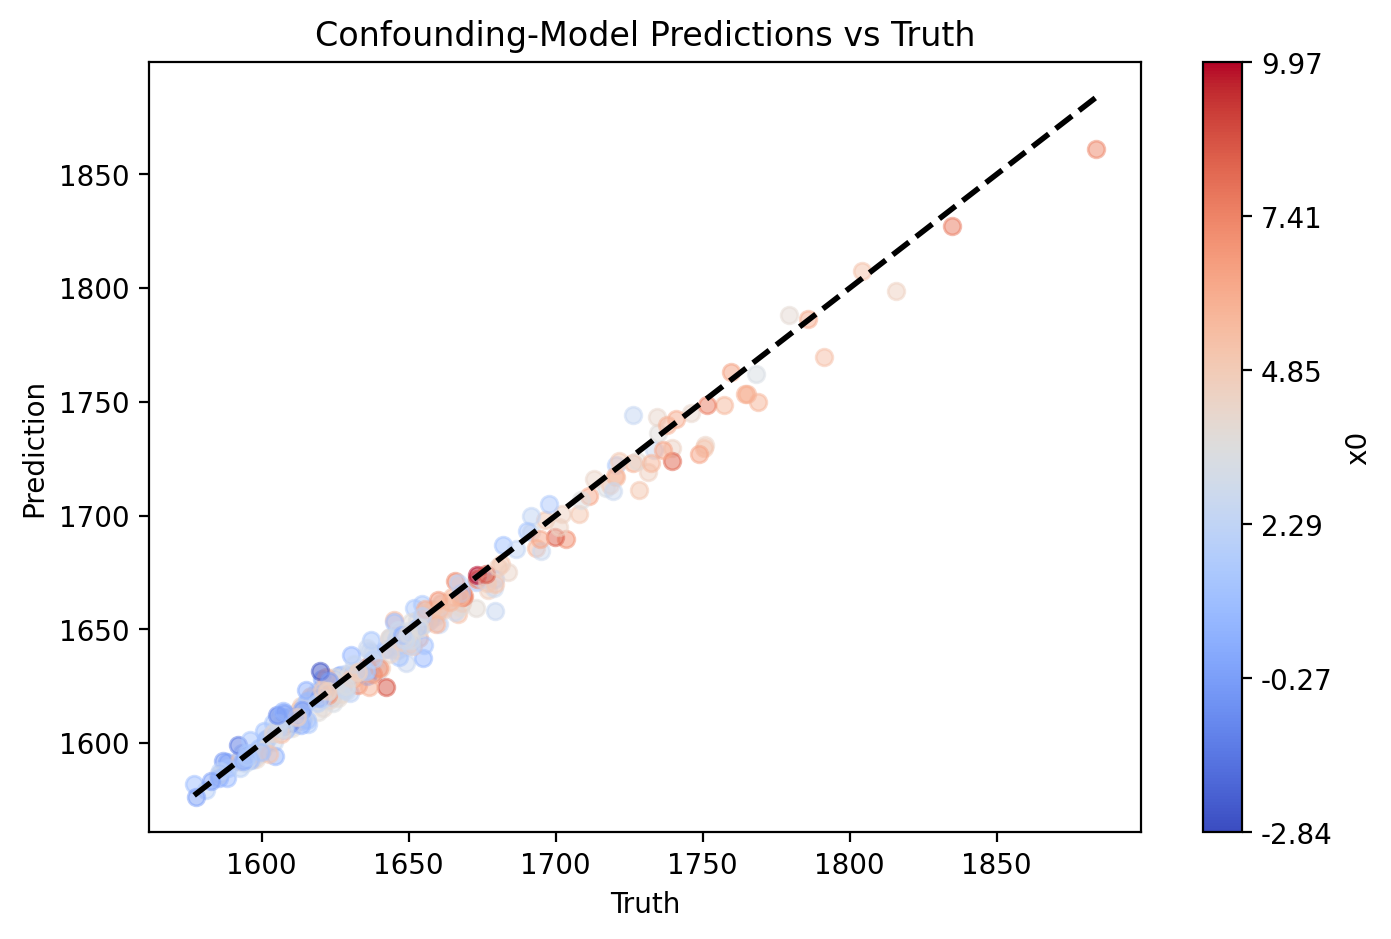

In [91]:
plot_prediction_vs_truth(net,X_test_scaled_sample,X_test_all_sample,y_test_sample,title="Confounding-Model Predictions vs Truth")

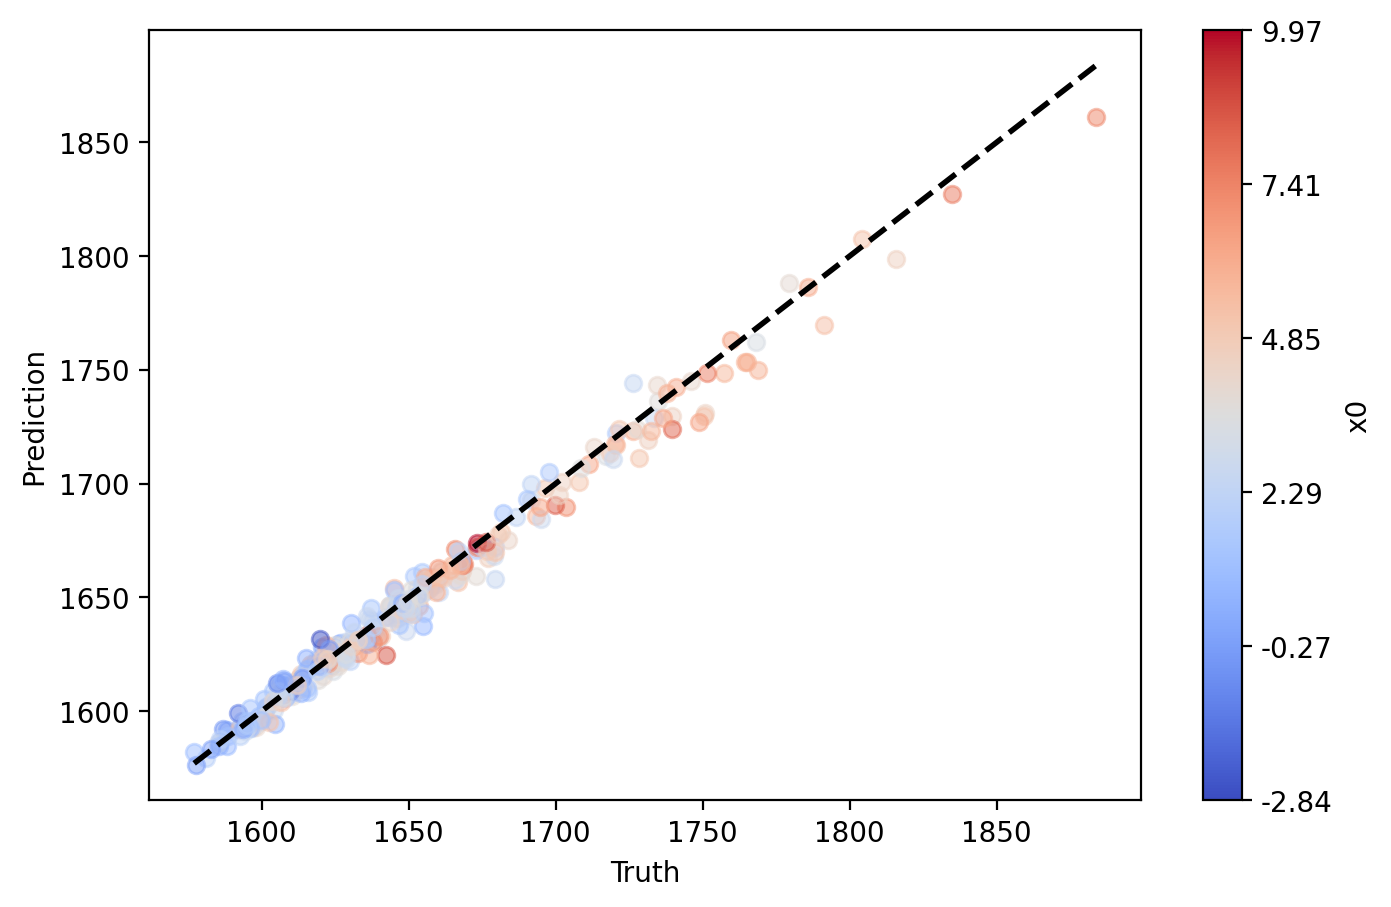

In [92]:
plot_prediction_vs_truth(net,X_test_scaled_sample,X_test_all_sample,y_test_sample,title="")

## ICE plots

In [103]:
import torch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def ice_plot(model, X_s, X, y, feature, num_points=None, off=0):
    device = next(model.parameters()).device
    
    # Initialize a figure and axis
    fig, ax = plt.subplots()
    if X.columns.get_loc(feature)>X.columns.get_loc('x1'):
        feature_index=X.columns.get_loc(feature)-1
    else:
        feature_index=X.columns.get_loc(feature)
    feature_index_o=X.columns.get_loc(feature)
    # Extract the unique feature values from the unscaled data
    feature_values = pd.unique(X.loc[:, feature].sort_values())
    feature_values_s = np.unique(np.sort(X_s[:, feature_index]))
    
    # Normalize the CGPA values for coloring
    cgpa_values = X.loc[:, 'x1'].values
    normalized_cgpa = (cgpa_values - np.min(cgpa_values)) / (np.max(cgpa_values) - np.min(cgpa_values))
    cmap = plt.get_cmap('coolwarm')

    # If num_points is specified, select a subset of equally spaced unique feature values
    if num_points is not None:
        idx = np.round(np.linspace(0, len(feature_values) - 1, num_points)).astype(int)
        feature_values = feature_values.iloc[idx]
        feature_values_s = feature_values_s[idx]

    XXX = X_s.copy()
    predictions_all = []

    # Loop through instances in the test set
    for instance, i in zip(XXX, range(len(X_s))):
        # Create an array to store predictions for this instance
        predictions = []
        original_prediction = model(torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)).item()

        # Loop through the unique feature values
        for val in feature_values_s:
            # Set the feature value for the current instance
            instance[feature_index] = val

            # Convert the instance to a PyTorch tensor and unsqueeze to add batch dimension
            instance_tensor = torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)

            # Get the prediction from the model
            with torch.no_grad():
                prediction = model(instance_tensor).item()
            predictions.append(prediction)

        predictions_all.append(predictions)

        # Plot the ICE curve for this instance in the color corresponding to CGPA value with transparency
        ax.plot(feature_values, predictions, color=cmap(normalized_cgpa[i]), alpha=0.5)
        
        # Plot the marker for the original value
        original_val = X.iloc[i, feature_index_o]
        ax.scatter(original_val, original_prediction, marker='o', color=cmap(normalized_cgpa[i]), zorder=10)

    # Calculate the mean of all ICE lines
    mean_predictions = np.mean(predictions_all, axis=0)

    # Plot the mean ICE curve in black and thicker
    ax.plot(feature_values, mean_predictions, color='black', linewidth=2)

    # Label the plot
    ax.set_xlabel(feature)
    ax.set_ylabel('Predictions')
    ax.set_title('ICE plot for {}'.format(feature))
    
    # Add colorbar for CGPA
    sm = ScalarMappable(cmap=cmap, norm=Normalize(0, 1))
    sm.set_array([])
    
    # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='x1')

    # Customize colorbar ticks
    min_val, max_val = np.min(cgpa_values), np.max(cgpa_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])

    # Show the plot
    plt.show()


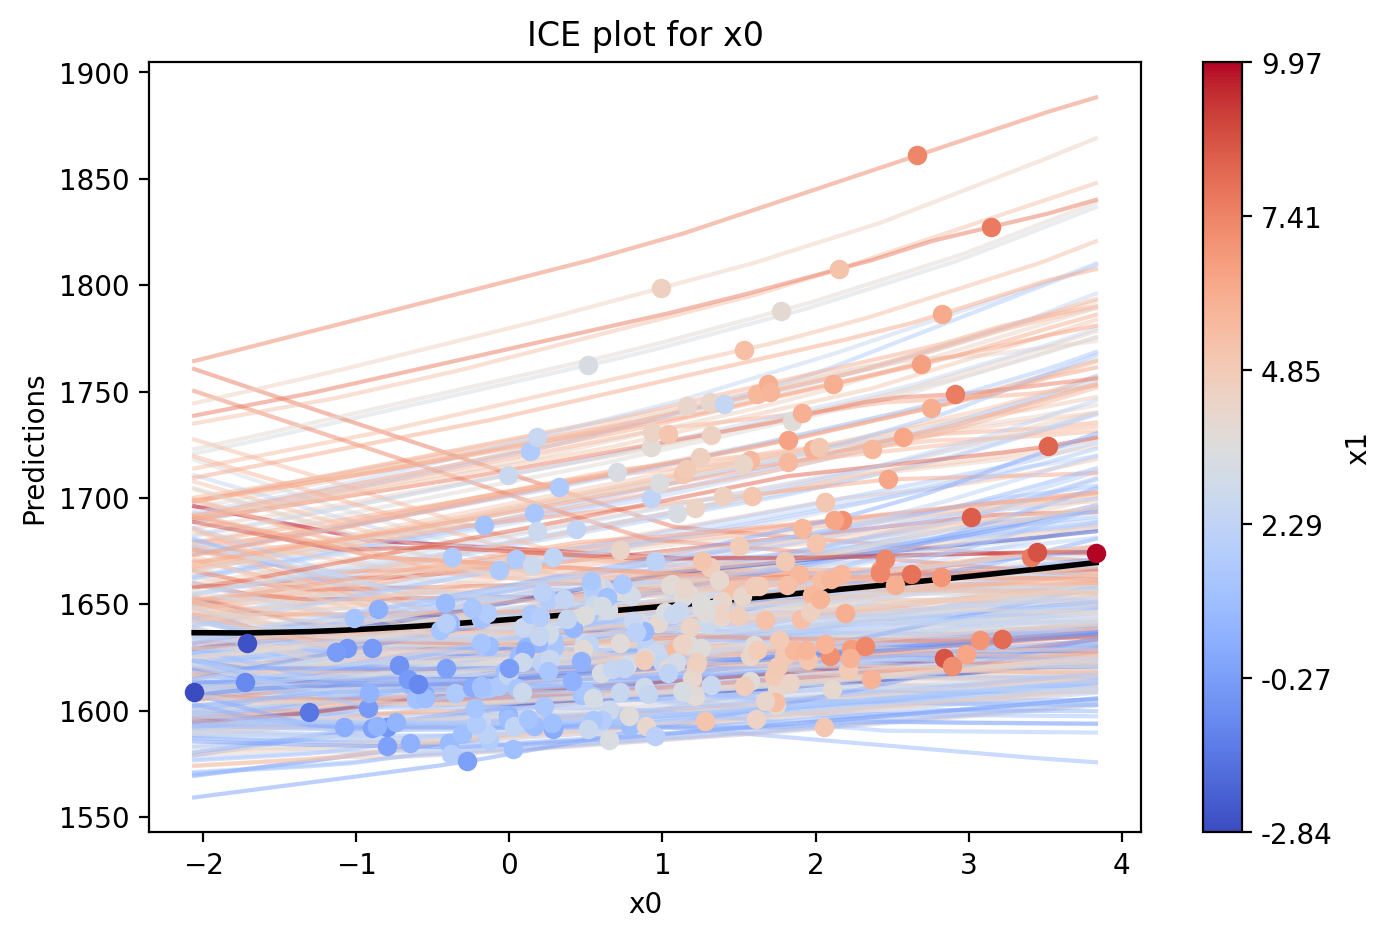

In [104]:
ice_plot(net, X_test_scaled_sample, X_test_all_sample, y_test_sample,'x0')
#ice_plot(net_full, X_test_scaled, X_test, y_test,'TOEFL Score','TOEFL Score')

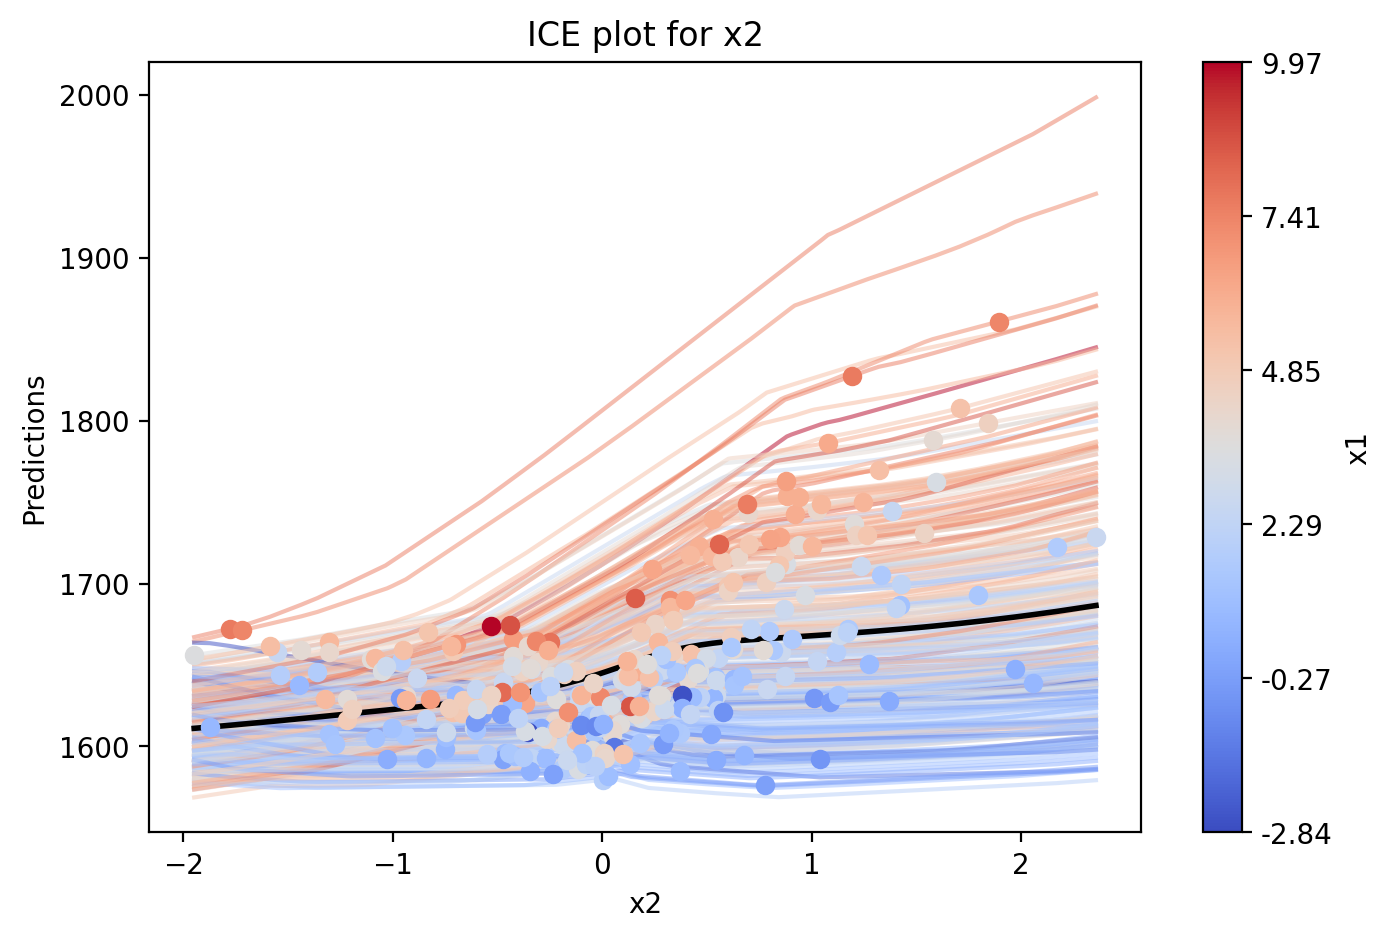

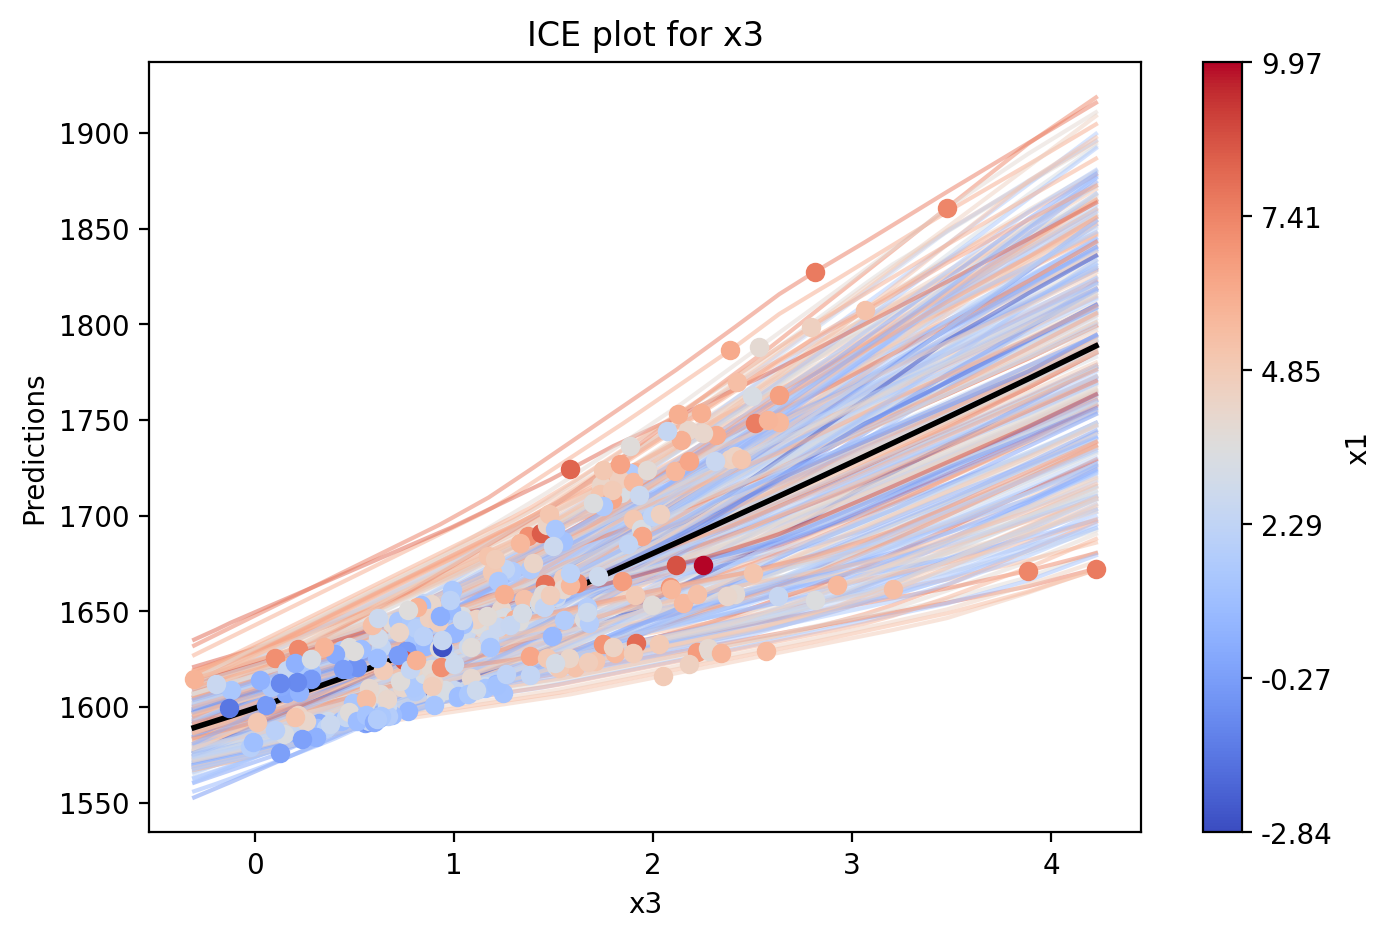

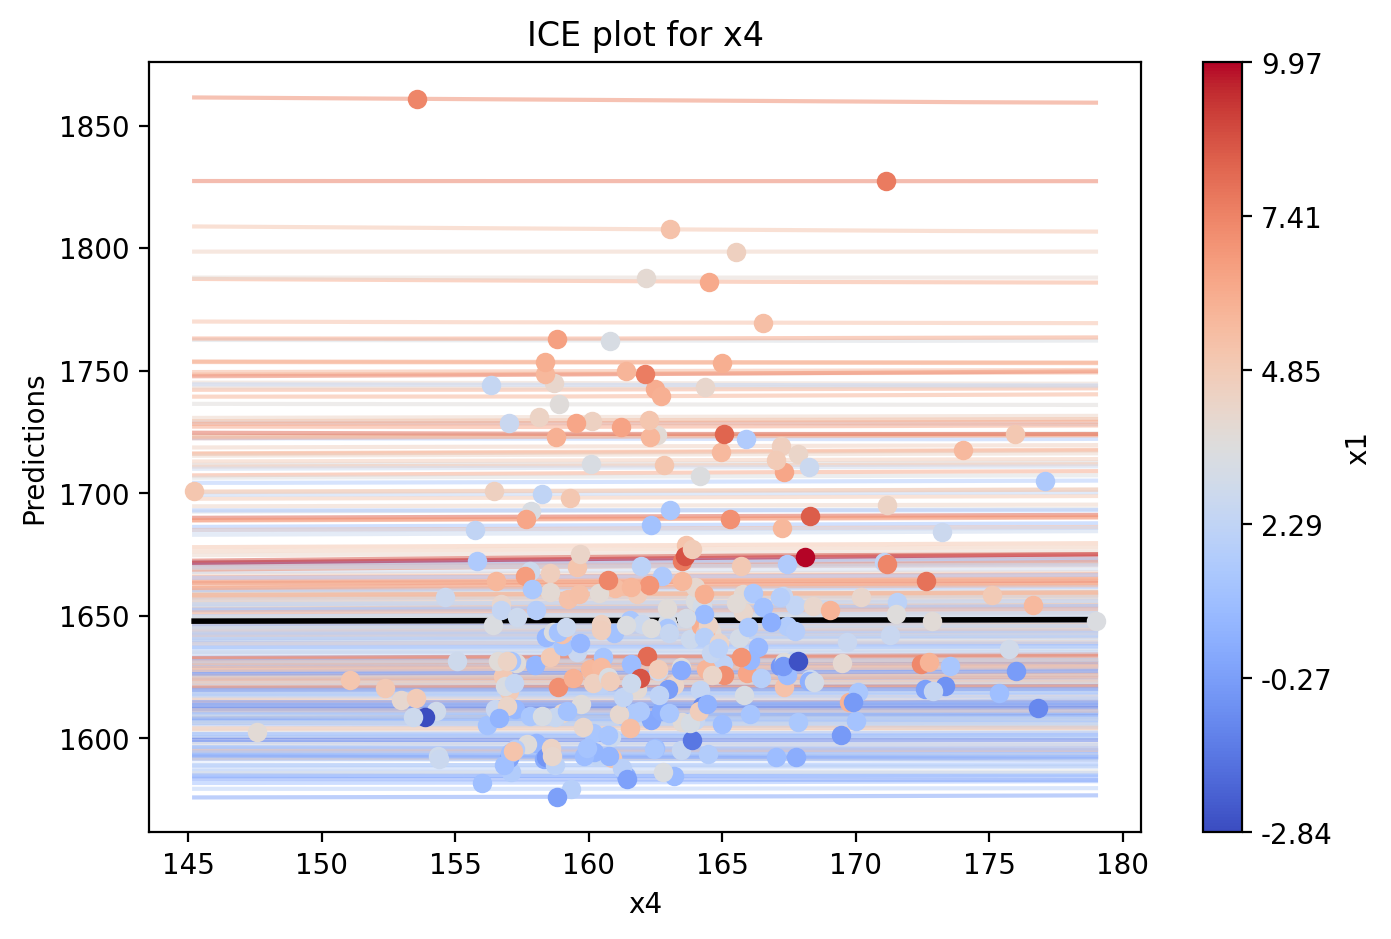

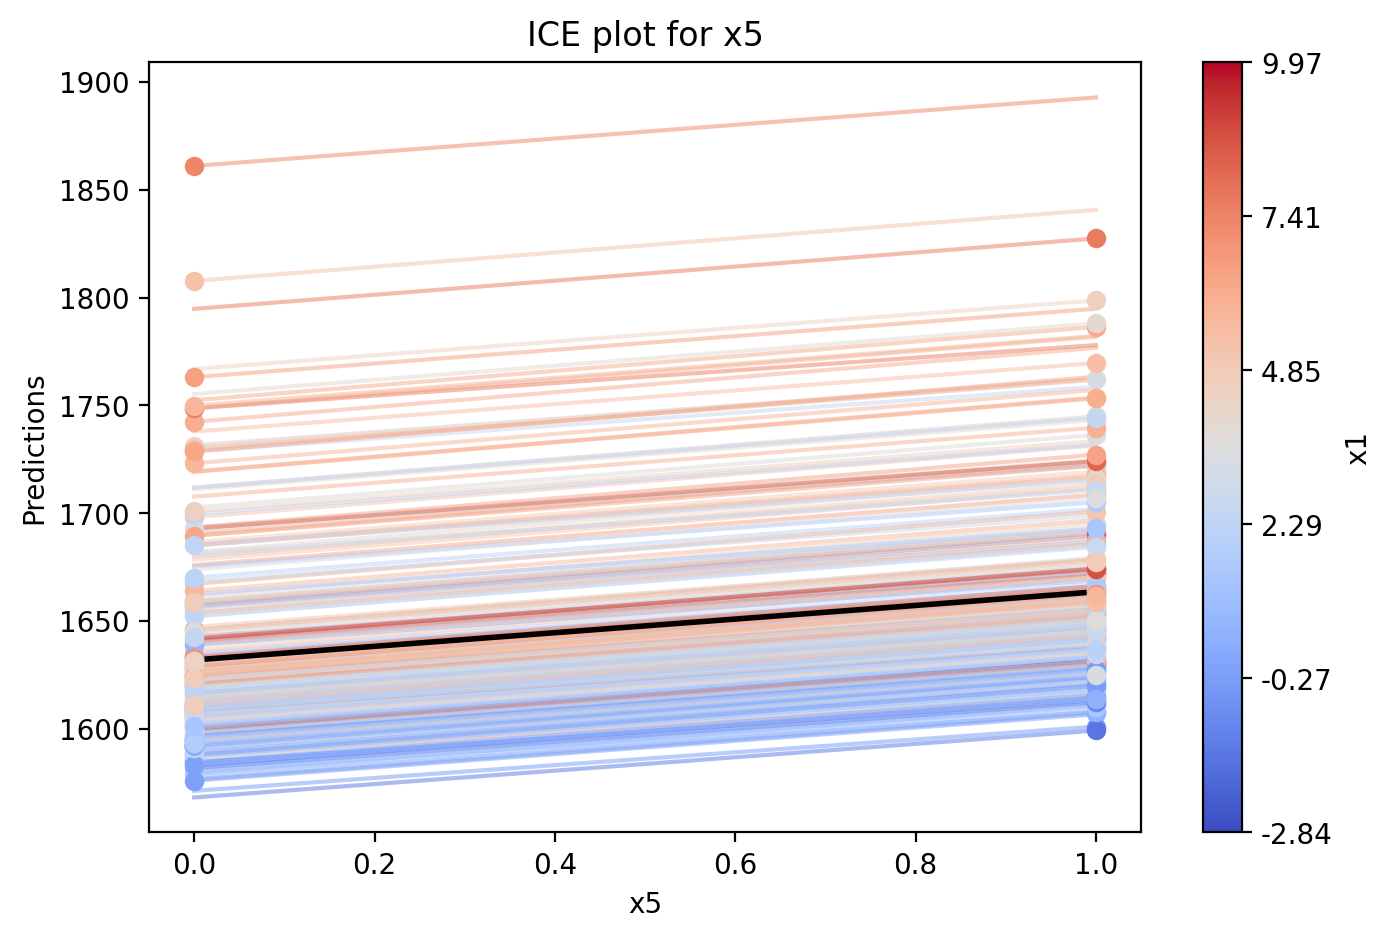

In [105]:
ice_plot(net, X_test_scaled_sample, X_test_all_sample, y_test_sample,'x2')
ice_plot(net, X_test_scaled_sample, X_test_all_sample, y_test_sample,'x3')
ice_plot(net, X_test_scaled_sample, X_test_all_sample, y_test_sample,'x4')
ice_plot(net, X_test_scaled_sample, X_test_all_sample, y_test_sample,'x5')


## KernelSHAP feature importance

In [59]:
from captum.attr import KernelShap

In [60]:
baseline_unscaled = X_test.mean(axis=0)

In [61]:
baseline_unscaled

x0      1.000645
x1      3.596130
x2      0.001764
x3      1.349328
x4    162.534424
x5      0.499725
dtype: float64

In [62]:
y_test_series = y_test_sample.iloc[:, 0]
device=torch.device('cpu')
worst_instance = torch.tensor(X_test_scaled_sample[y_test_series.argmin()]).unsqueeze(0).float().to(device)
best_instance = torch.tensor(X_test_scaled_sample[y_test_series.argmax()]).unsqueeze(0).float().to(device)

baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)

baseline_clone = baseline.clone()
baseline_clone[0][4] = 1
print(baseline_clone)
print(worst_instance)
print(best_instance)
#baseline_value=net(torch.Tensor(X_test_scaled).to(device)).mean().item()
print(net(best_instance))
print(net(worst_instance))
#print(net(torch.Tensor(X_test_scaled).to(device)).mean())
print(net(baseline_clone))


tensor([[-3.5662e-03,  5.0382e-03, -2.1007e-04,  7.7575e-03,  1.0000e+00]])
tensor([[-0.9806,  0.0399, -1.7735, -1.1798, -0.9977]])
tensor([[ 1.6565,  2.3655,  2.7841, -1.6289, -0.9977]])
tensor([[1860.9819]], grad_fn=<AddmmBackward0>)
tensor([[1581.9045]], grad_fn=<AddmmBackward0>)
tensor([[1662.2115]], grad_fn=<AddmmBackward0>)


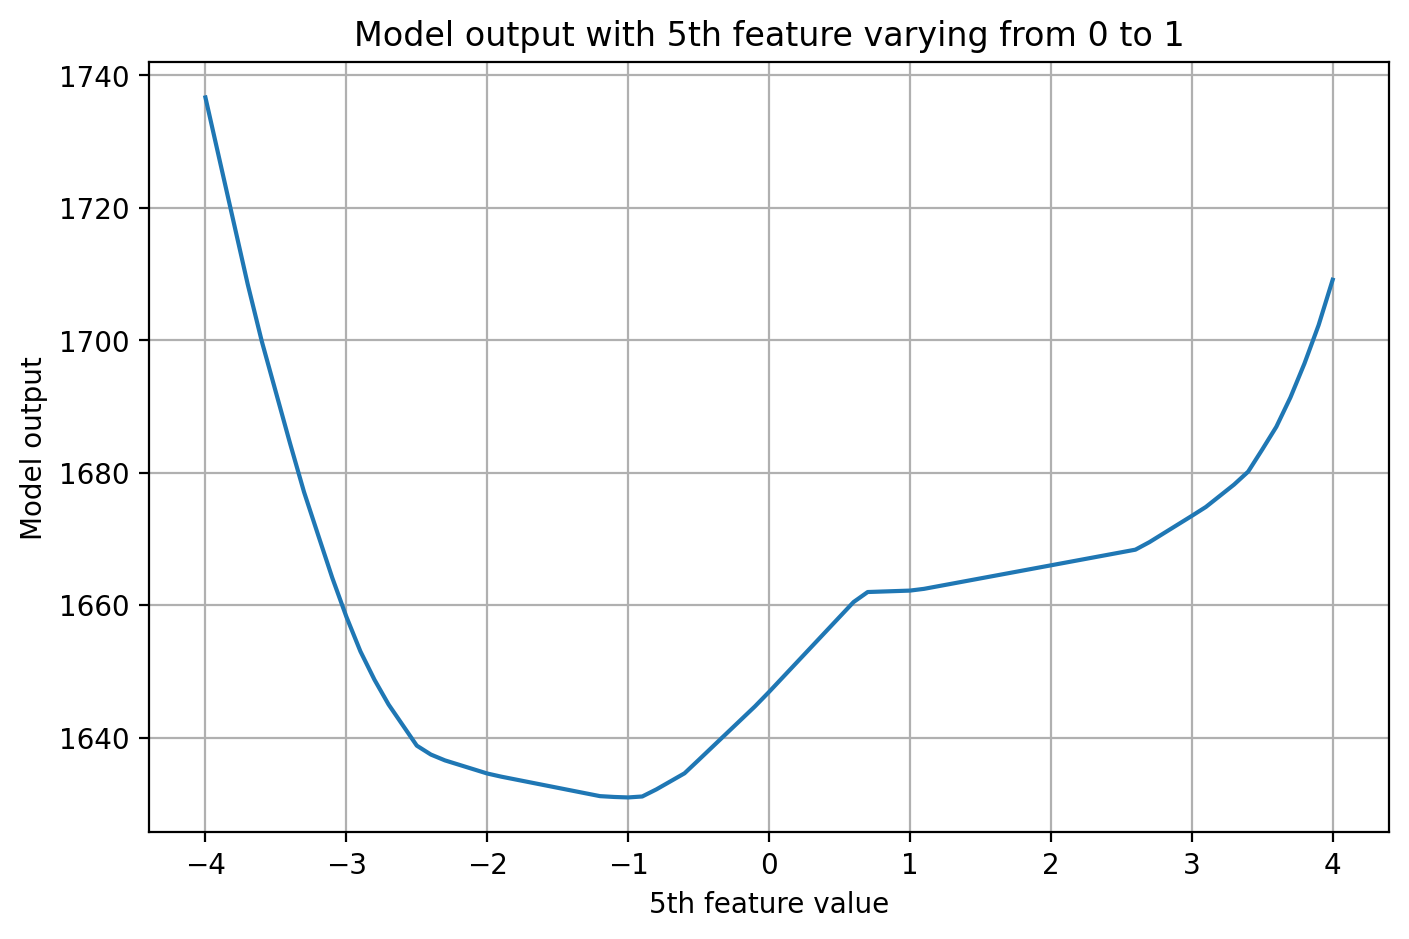

In [43]:
import matplotlib.pyplot as plt
import torch

# Assuming your model is named net_full and your baseline is a tensor
baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)

# Initialize a list to store the outputs
outputs = []

# Change the 5th value from 0 to 1 in 0.1 steps
for i in torch.arange(-4, 4.1, 0.1):
    baseline_clone = baseline.clone()
    baseline_clone[0][4] = i  # assuming the 5th feature is at index 4 (0-indexed)
    output = net(baseline_clone)
    outputs.append(output.detach().cpu().numpy().flatten())  # Flatten the output

# Plot the outputs
plt.plot(torch.arange(-4, 4.1, 0.1).numpy(), outputs)
plt.xlabel("5th feature value")
plt.ylabel("Model output")
plt.title("Model output with 5th feature varying from 0 to 1")
plt.grid(True)
plt.show()


In [63]:
# Instantiate KernelShap
ks = KernelShap(net)

In [64]:
worst_shap_values = ks.attribute(worst_instance, baseline_clone,n_samples=30000)
best_shap_values = ks.attribute(best_instance, baseline_clone,n_samples=30000)
baseline_shap_values=ks.attribute(baseline_clone, baseline_clone,n_samples=30000)

In [65]:
worst_shap_np = worst_shap_values.cpu().detach().numpy()
best_shap_np = best_shap_values.cpu().detach().numpy()

In [66]:
best_shap_np

array([[ 23.091166  ,  78.55821   , 128.87361   ,  -0.47283554,
        -31.30634   ]], dtype=float32)

In [67]:
import shap
def shap_vis(values,baseline_shap_values,data):
    print(values)
    print(baseline_shap_values)
    print(data)

    # define the corresponding SHAP values
    shap_values = values

    # get the index of the baseline value
    baseline_index = np.argmin(np.abs(shap_values))

    # get the baseline value
    baseline_value = baseline_shap_values

    # create a SHAP Explanation object
    expl = shap.Explanation(values=shap_values,
                        base_values=baseline_value,
                        data=data,
                        feature_names=X_train.columns)

    # create a SHAP waterfall plot
    shap.plots.waterfall(expl)

    shap.plots.force(expl)

[ 23.091166    78.55821    128.87361     -0.47283554 -31.30634   ]
1662.2115478515625
x0      2.663692
x2      1.893728
x3      3.478006
x4    153.564981
x5      0.000000
Name: 23126, dtype: float64


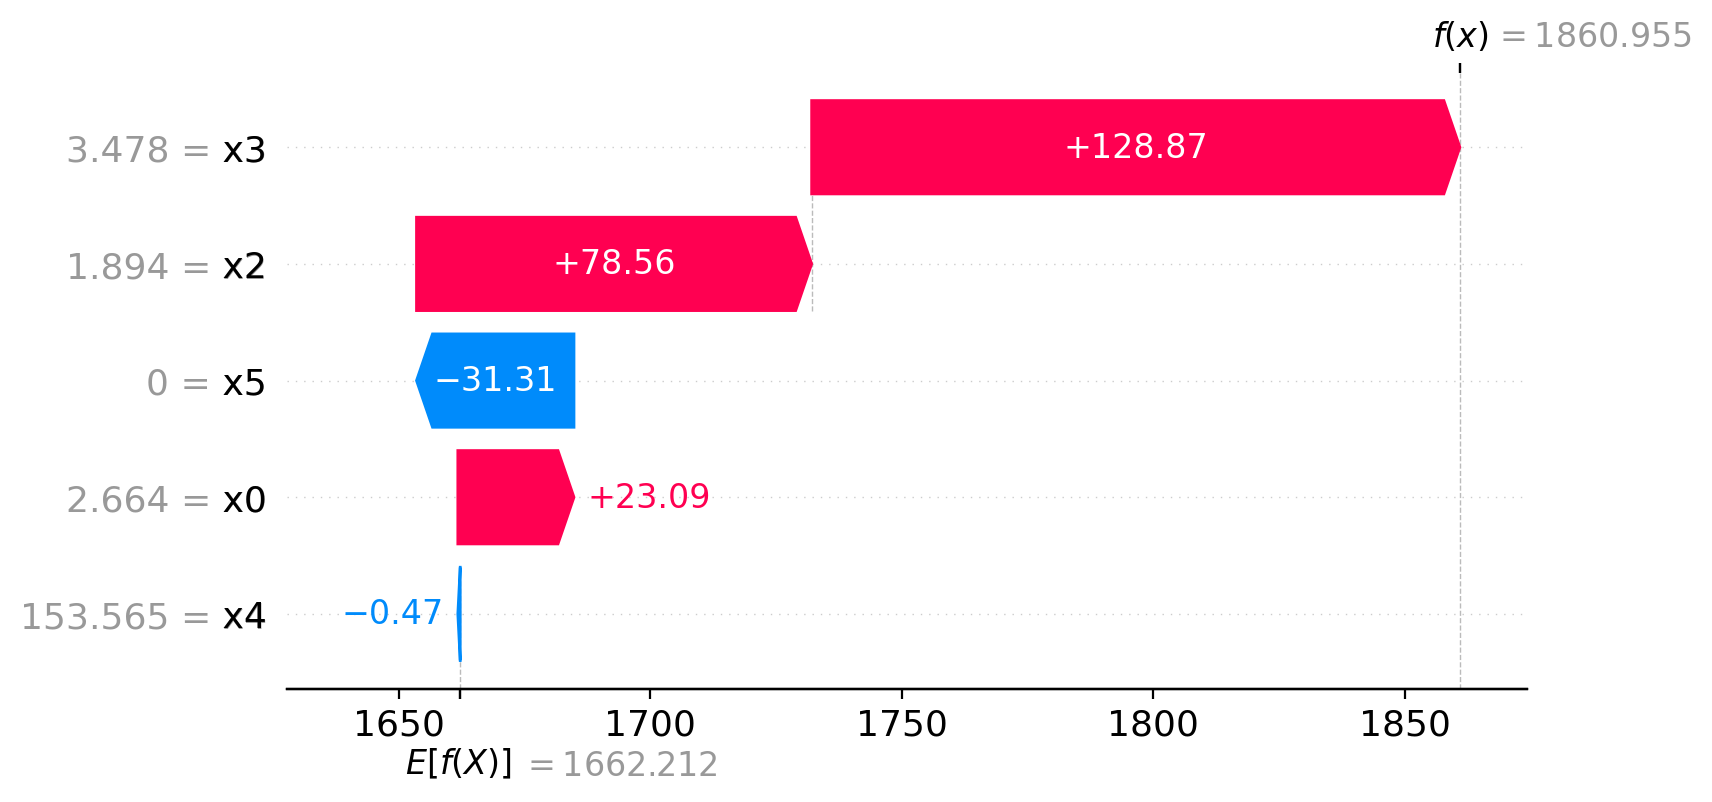

In [68]:
shap_vis(best_shap_np[0],net(baseline_clone).item(),X_test_sample.iloc[y_test_series.argmax()])

[ -5.107316     0.843277   -45.834713    -0.16026402 -30.047821  ]
1662.2115478515625
x0      0.021823
x2      0.029714
x3     -0.006364
x4    156.025954
x5      0.000000
Name: 22115, dtype: float64


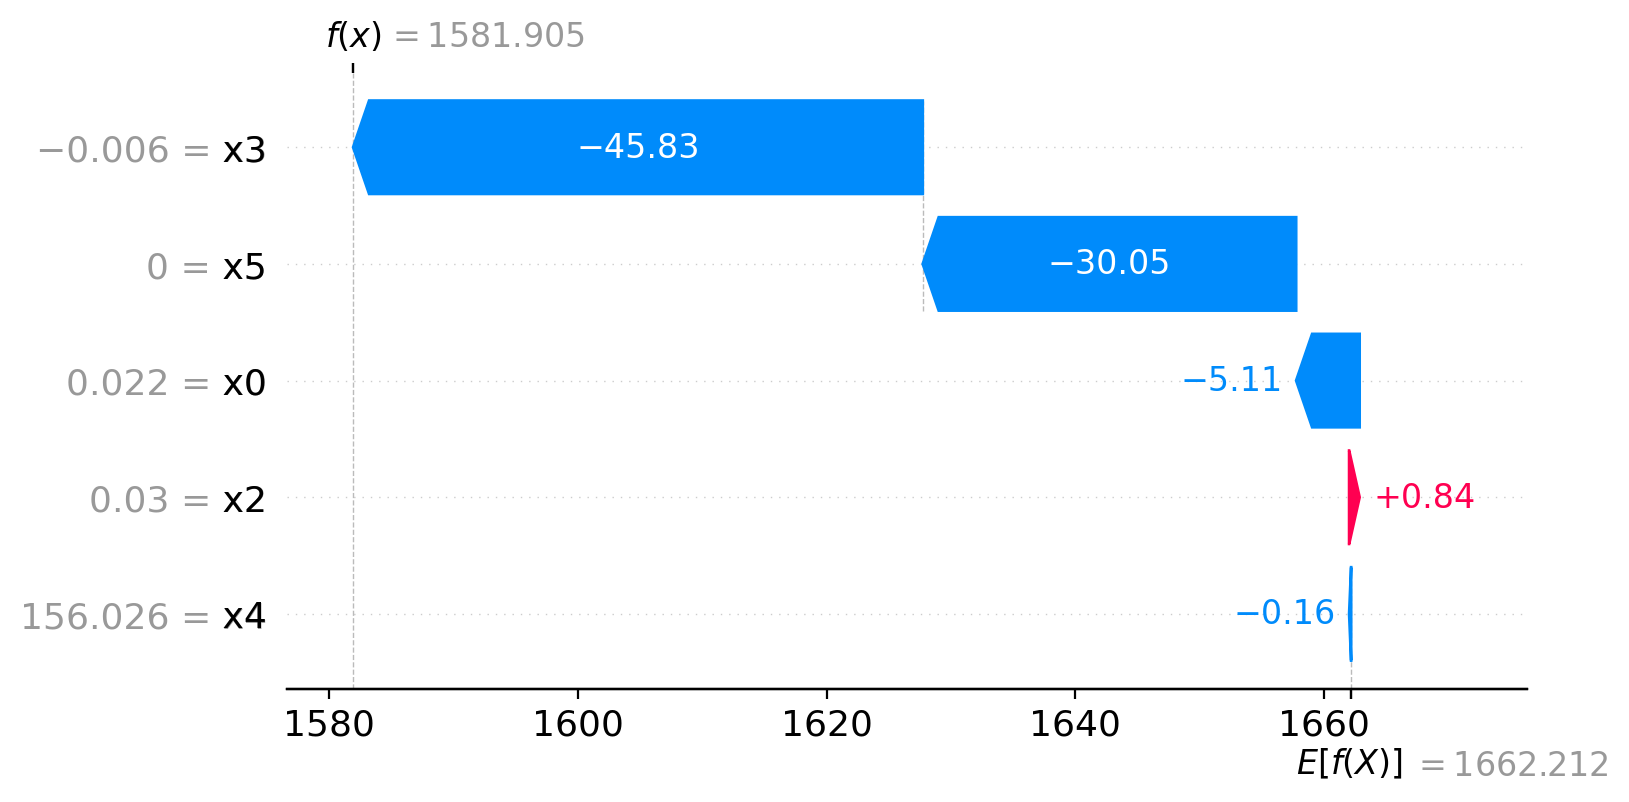

In [69]:
shap_vis(worst_shap_np[0],net(baseline_clone).item(),X_test_sample.iloc[y_test_series.argmin()])

## Feature importance

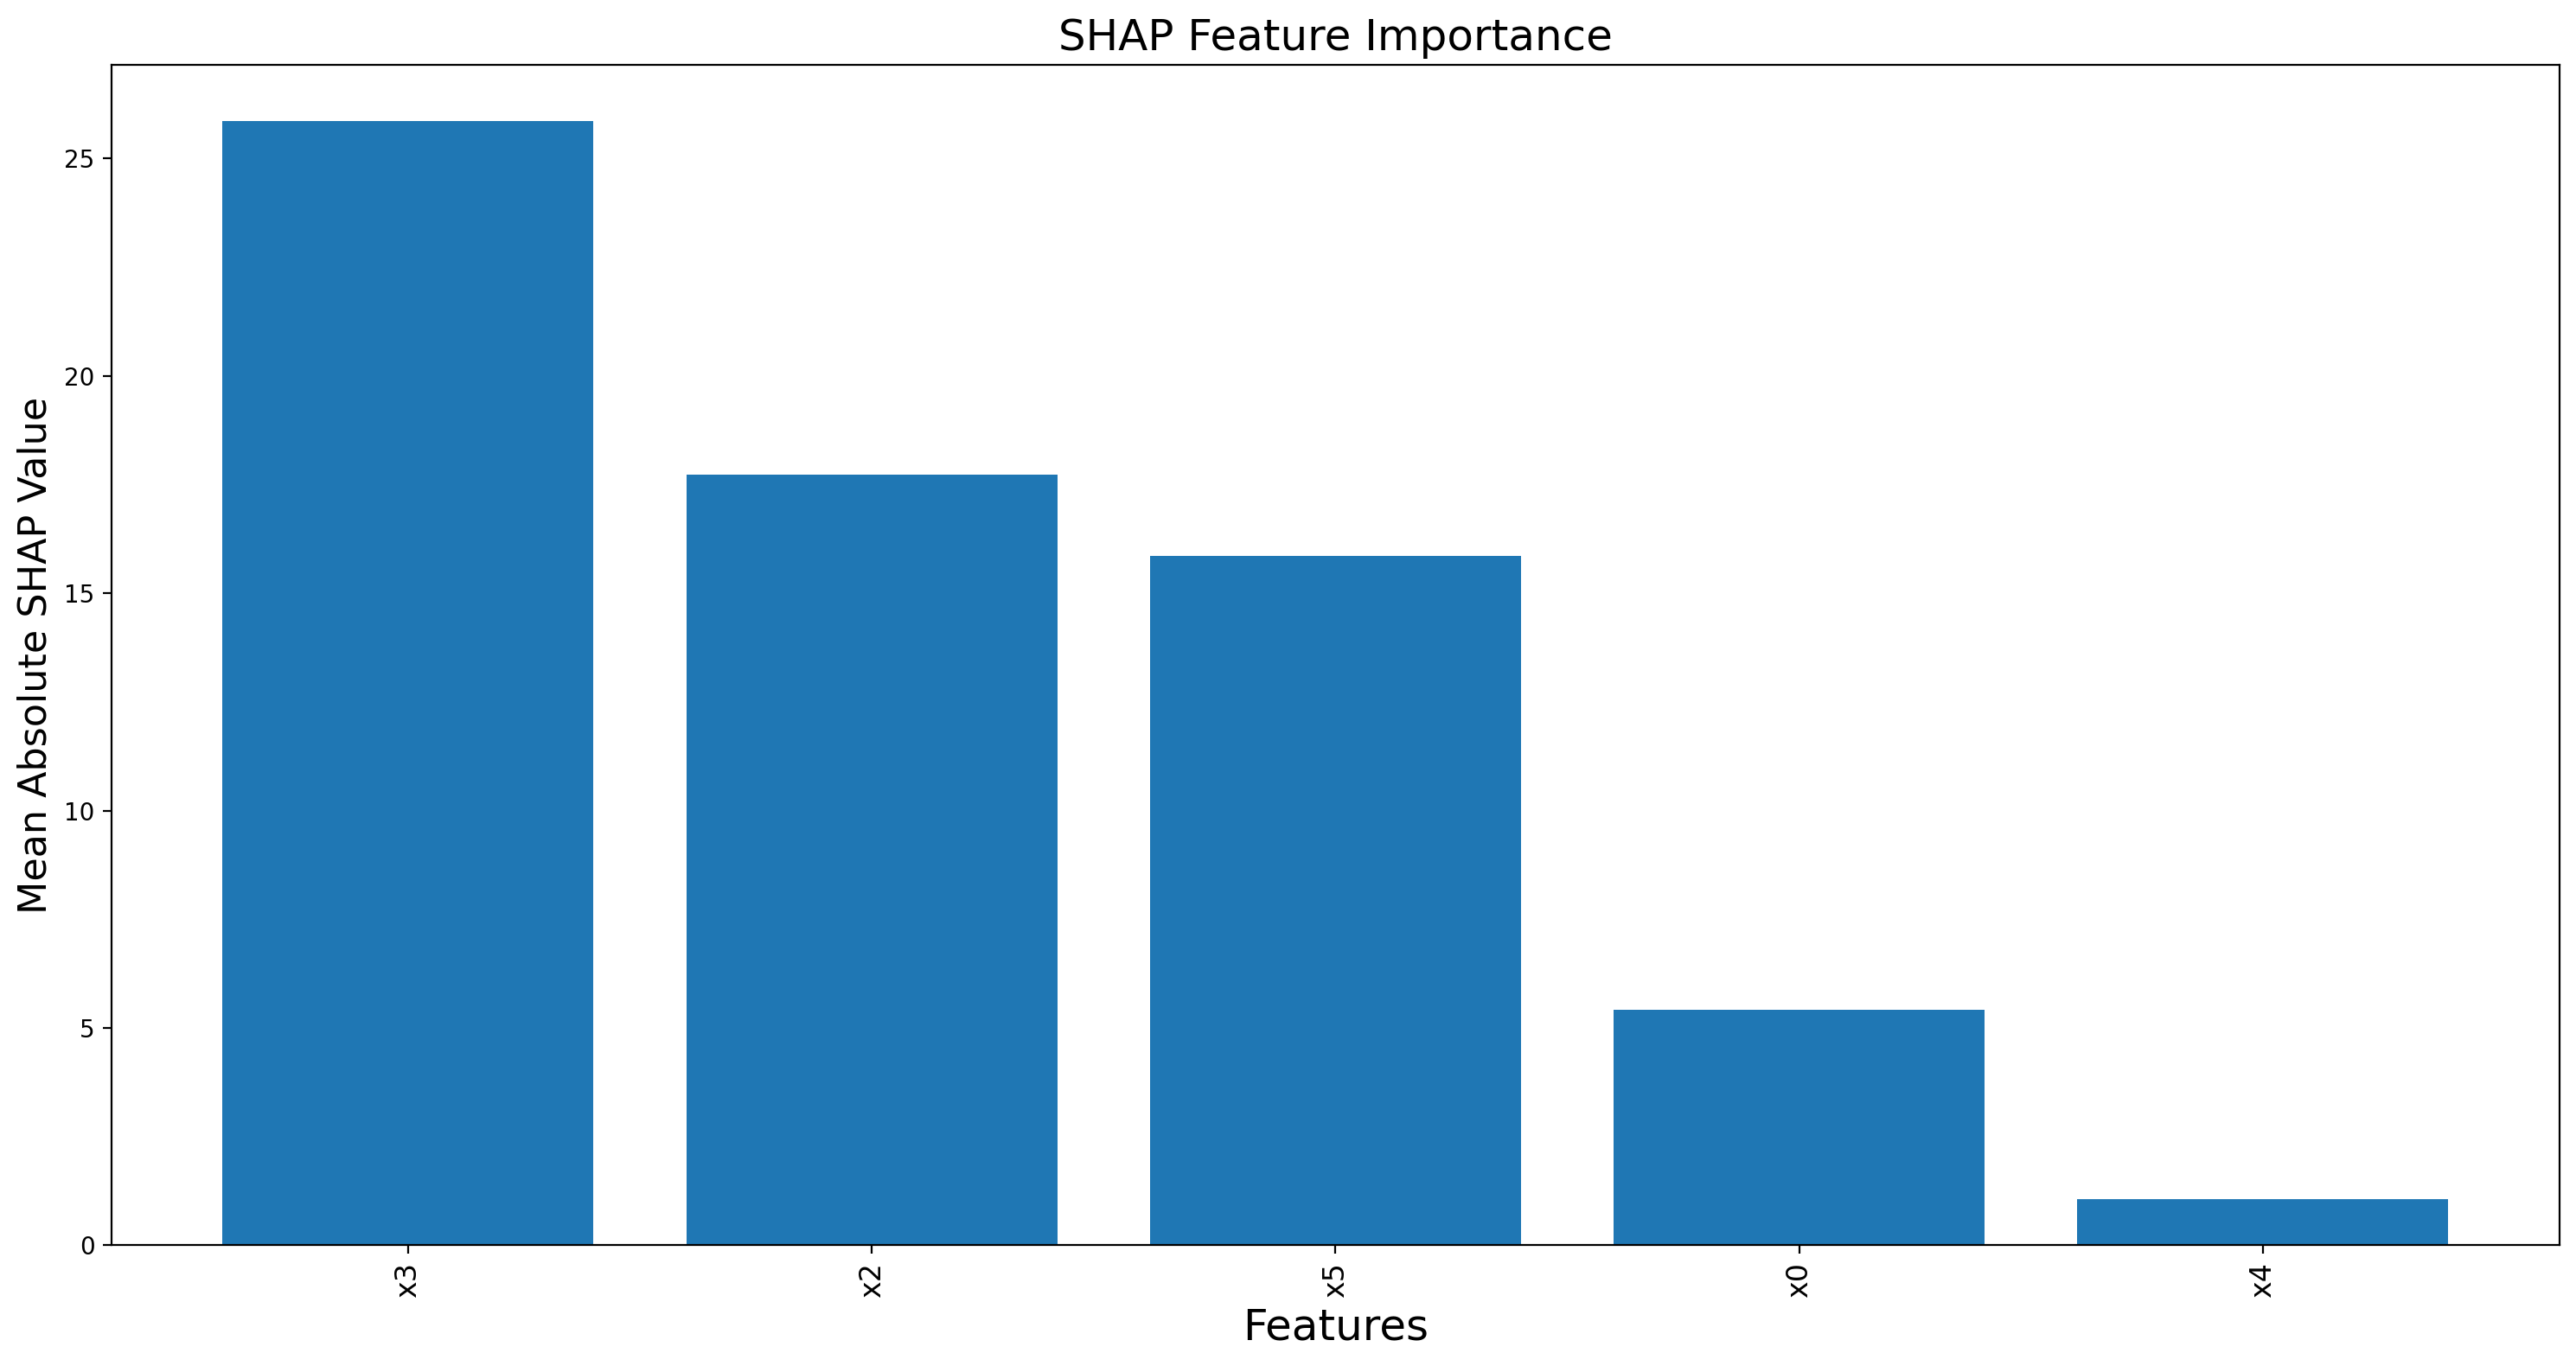

In [70]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt

# Instantiate KernelShap
shap = KernelShap(net)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled_sample)  # assuming X_train is numpy array

# Attribute SHAP values
global_shap_values = []

for instance in X_test_t:
    shap_values = shap.attribute(instance.unsqueeze(0).float().to(device), baseline_clone,n_samples=5000)
    global_shap_values.append(shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test_sample.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(15, 8),dpi=200)
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance',fontsize=18)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Mean Absolute SHAP Value',fontsize=16)
plt.xticks(rotation=90,fontsize=12)
plt.tight_layout()
plt.show()


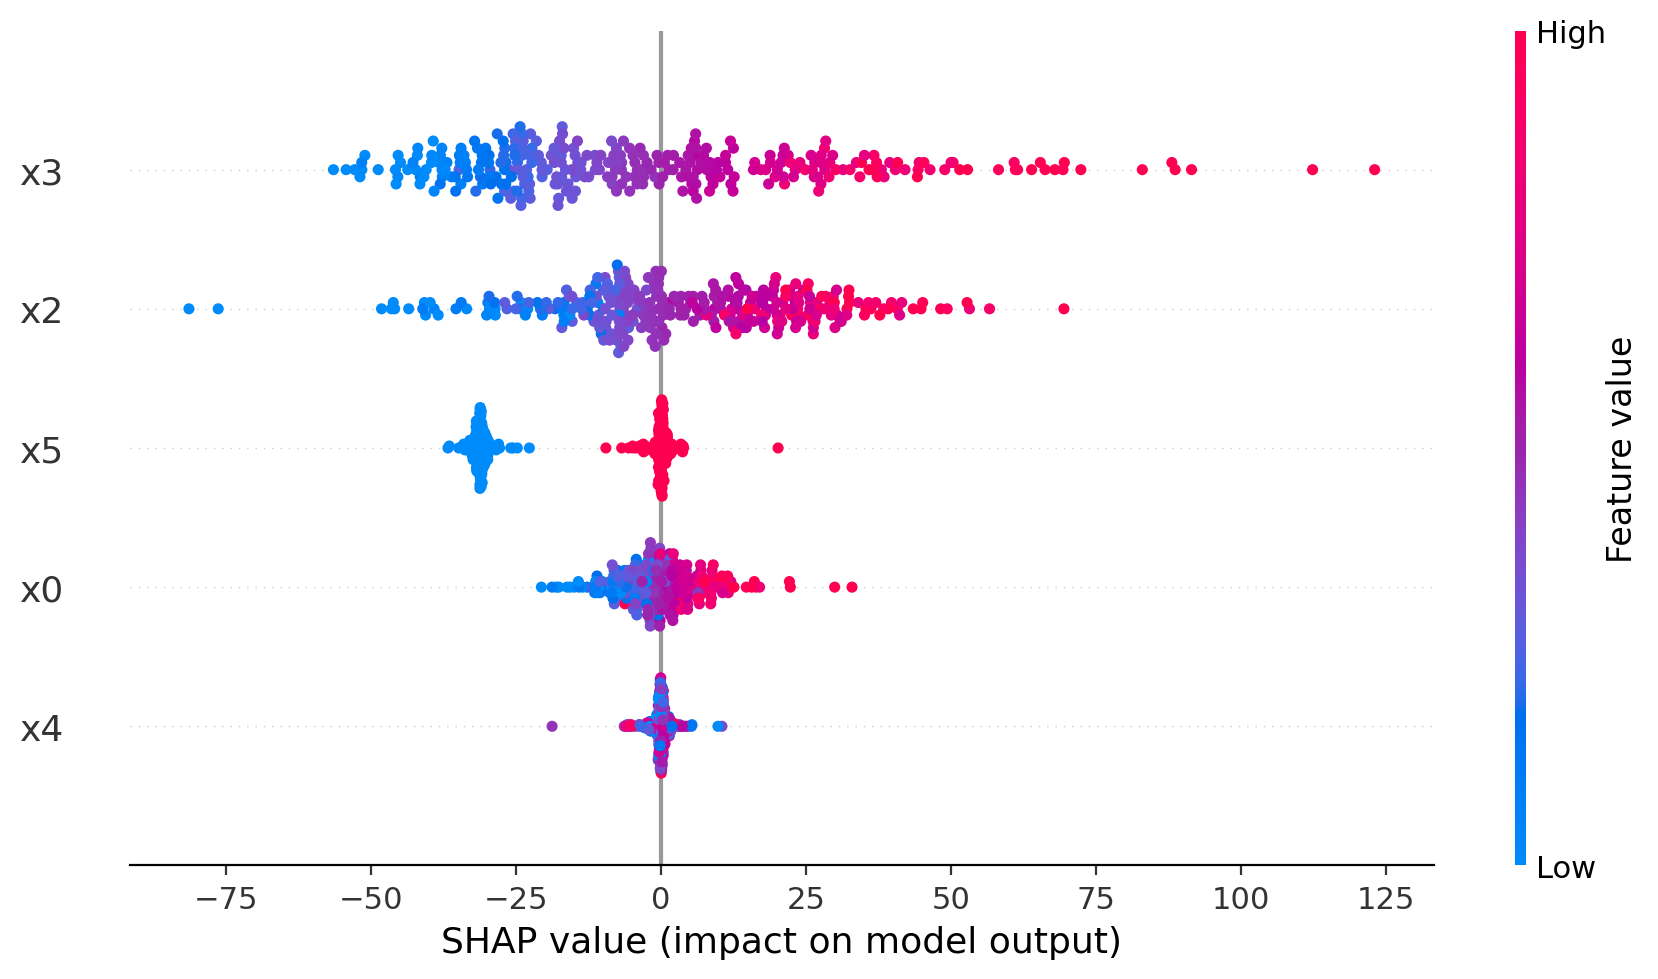

In [71]:
import shap

# Convert the global_shap_values back to a format that shap.summary_plot can understand
global_shap_values = global_shap_values.reshape(global_shap_values.shape[0], -1)

# Create a SHAP summary plot
shap.summary_plot(global_shap_values, X_test_scaled_sample, feature_names=X_test_sample.columns,plot_size=(9,5))
